In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets, vocab

from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from torch_cluster import random_walk

import numpy as np
import warnings
import re
import time
import os
import logging
import pandas as pd
import random
import sys
import math
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

eps = np.finfo(float).eps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
use_cuda = torch.cuda.is_available()
use_cuda = False
if use_cuda:
    device = torch.device("cuda")
    torch.cuda.set_device(1)
else:
    device = torch.device("cpu")

In [5]:
# Settings
# max_sequence length
# num_class
# vocab_size
batch_size = 1
walk_length = 16

### Dataloader

In [6]:
# dataset
path = '../data/ENZYMES/'
dataset = TUDataset(path, name='ENZYMES')
dataset = dataset.shuffle()
n = len(dataset) // 10

test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [7]:
data = train_loader.__iter__().__next__()
x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y

### Model definitions

In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, k, num_heads=8):
        super(AttentionLayer, self).__init__()
        self.k = k
        self.num_heads = num_heads
        
        # determine queries, keys, values
        self.key_layer = nn.Linear(self.k, self.k * self.num_heads, bias=False)
        self.query_layer = nn.Linear(self.k, self.k * self.num_heads, bias=False)
        self.value_layer = nn.Linear(self.k, self.k * self.num_heads, bias=False)
        
        # project down all cat-ed heads
        self.unify_layer = nn.Linear(self.num_heads * k, k)
    
    def forward(self, x):
        # get batch size, t sentences of k items
        b_sz, t_sz, k_sz = x.size()
        h_sz = self.num_heads
        
        keys = self.key_layer(x).view(b_sz, t_sz, h_sz, self.k)
        queries = self.query_layer(x).view(b_sz, t_sz, h_sz, self.k)
        values = self.value_layer(x).view(b_sz, t_sz, h_sz, self.k)
    
        # compute dot products (k x k). Same op for every head, so fold in to the
        # batch dim
        # q, k, v, (b, t, h, k) -> (b, h, t, k) -> (bh, t, k)
        # and for the key (bh, t, k) -> (bh, k, t) to be able to use bmm
        #
        keys = keys.transpose(1, 2).contiguous().view(b_sz * h_sz, t_sz, k_sz)
        queries = queries.transpose(1, 2).contiguous().view(b_sz * h_sz, t_sz, k_sz)
        values = values.transpose(1, 2).contiguous().view(b_sz * h_sz, t_sz, k_sz)
        
        # intermediate scaling
        queries = queries / ( self.k  ** (1./4.))
        keys = keys / ( self.k  ** (1./4.))
        
        # final transpose for the bmm, out -> (b*h, t, t)
        raw_weights = torch.bmm(queries, keys.transpose(1, 2))
        
        # row wise softmax normalize
        weights = F.softmax(raw_weights, dim=2)
        
        # apply self attention to the values
        out = torch.bmm(weights, values).view(b_sz, h_sz, t_sz, k_sz)
        
        # Unify attention heads
        # reshuffle (b, h, t, k) -> (b, t, h, k) -> (b, t, h*k) with all the heads catted
        # ontop of each other to be able to down project
        out = out.transpose(1, 2).contiguous().view(b_sz, t_sz, h_sz * k_sz)
        
        # project down
        out = self.unify_layer(out)
        
        return out
    
    
class TransformerBlock(nn.Module):
    def __init__(self, k, num_heads):
        super(TransformerBlock, self).__init__()
        
        self.attention = AttentionLayer(k, num_heads)
        
        self.layer_norm1 = nn.LayerNorm(k)
        self.layer_norm2 = nn.LayerNorm(k)
        
        self.mlp = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k)
        )
    
    def forward(self, x):
        # Attention block
        x_att = self.attention(x)
        # Residual + norm
        x = self.layer_norm1(x + x_att)
        # MLP
        x_mlp = self.mlp(x)
        out = self.layer_norm2(x + x_mlp)
        return out
    
    
class Transformer(nn.Module):
    def __init__(self, k, num_heads, depth, num_tokens, num_classes):
        super(Transformer, self).__init__()
        
        self.num_tokens = num_tokens
        
        # Embedding tokens and position layers
        self.token_embed_layer = nn.Embedding(num_tokens, k)
        
        # Transformer blocks
        self.tf_network = []
        for _ in range(depth):
            self.tf_network.append(TransformerBlock(k, num_heads))

        self.tf_network = nn.Sequential(*self.tf_network)
        
        # Sequence to class output
        self.output_layer = nn.Linear(k, num_classes)
        
    def forward(self, x):
        # in (b, t) tensor with int values representing words
        # out (b, c) tensor logprobs over c classes
        
        # generate token embeddings
        tokens = self.token_embed_layer(x)
        
        b_sz, t_sz, k_sz = tokens.size()
        
        # Transformer forward
        x = self.tf_network(tokens)
        
        # Average pool over t dimension and project to class probabilities
        x = self.output_layer(x.mean(dim=1))
        
        # Optional (auto-regressive) transformer
        # no looking ahead, enforce via mask, prior to softmax
#         indices = torch.triu_indices(t, t, offset=1)
#         x[:, indices[0], indices[1]] = float('-inf')
        
        out = F.log_softmax(x, dim=1)
        
        return out

In [20]:
def one_hot(labels, n_class):

    # Ensure labels are [N x 1]
    if len(list(labels.size())) == 1:
        labels = labels.unsqueeze(1)

    mask = torch.DoubleTensor(labels.size(0), n_class).fill_(0)

    # scatter dimension, position indices, fill_value
    return mask.scatter_(1, labels, 1)

In [21]:
EMBED_DIM = 128
num_classes = 6
vocab_size = 128
num_heads = 8
depth = 6
p, q = 1, 1
num_epochs = 16
# k, num_heads, depth, seq_length, num_tokens, num_
model = Transformer(EMBED_DIM, num_heads, depth, vocab_size, num_classes).to(device)

In [22]:
lr_warmup = 10000
batch_size = 16
lr = 1e-3
opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss_func = nn.NLLLoss()

In [23]:
def train(model, dataset, opt, sch, loss_func, device):
    model.train()
    batch_loss = 0
    for graph in dataset:
        x, edge_index, y = graph.x, graph.edge_index, graph.y
        edge_index = edge_index.to(device)
        x = x.to(device)
        y = y.to(device)
        subset = torch.arange(x.size(0), device=edge_index.device)
        walks = random_walk(edge_index[0], edge_index[1], subset, walk_length, p, q, x.size(0))
        # model forward
        y = y.repeat(walks.size(0),)
        y_pred = model(walks)

        loss = loss_func(y_pred, y)
        
        batch_loss += loss.item() / x.size(0)
        
        opt.zero_grad()
        loss.backward()
        
        opt.step()
        sch.step()
        
    return batch_loss / len(dataset)


def validate(model, dataset, device):
    model.eval()
    batch_acc = 0
    
    for graph in dataset:
        x, edge_index, y = graph.x, graph.edge_index, graph.y
        edge_index = edge_index.to(device)
        x = x.to(device)
        y = y.to(device)
        subset = torch.arange(x.size(0), device=edge_index.device)
        walks = random_walk(edge_index[0], edge_index[1], subset, walk_length, p, q, x.size(0))
        # model forward
        y = y.repeat(walks.size(0),)
        y_pred = model(walks)
        
        pred = y_pred.max(dim=1)[1]
        correct = pred.eq(y).sum().item()
        correct /= y.size(0)
        batch_acc += (correct * 100)
    
    return batch_acc / len(dataset)
    

In [24]:
train_loss = []
valid_acc = []

In [ ]:
# Main epoch loop
num_epochs = 5
for epoch in range(num_epochs):
    print("Epoch: {}".format(epoch))
    t_loss = train(model, train_dataset, opt, sch, loss_func, device)
    train_loss.append(t_loss)
    
    v_acc = validate(model, test_dataset, device)
    valid_acc.append(v_acc)

Epoch: 0


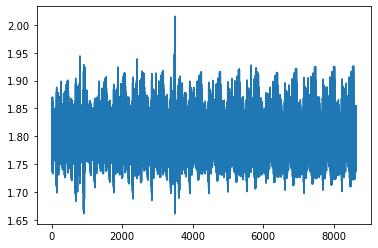

In [20]:
plt.plot(loss_hist)

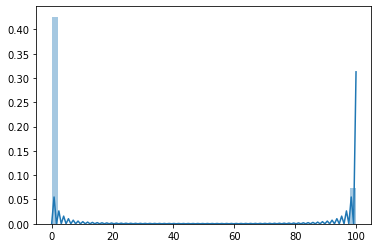

In [23]:
sns.distplot(train_acc)

In [19]:
# refractor into nice train/valide loop
# add positional encoding
# tune p, q parameters?
# investigate acc/loss behaviour
# investigate the dataloader + rw walk size
# acc per batch
# test an example
# test accuracy against node2vec + classifier with an identical number of waits
# test accuracy against GraphC + TopKPool
# integrate to use node information
# lit review
#